# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns
import time
import pickle
import tensorflow as tf


from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

INFO:bayesflow:Using backend 'tensorflow'


Using CAMB 1.6.1 installed at C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\camb


# Data generating process

## Definitions

In [2]:
def generate_logPK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 1, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    # noise = rng.normal(0, noise_level * P_k)
    # P_k_noisy = P_k + noise

    # Step 2: Apply log10 to each output
    log_k = np.log10(k_vals)
    #log_P_k_noisy = np.log10(P_k_noisy)
    
    
    
    
    log_P_k_clean = np.log10(P_k)

    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise
    
    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {     
        'log_k': log_k,
        'log_P_k_noisy': log_P_k_noisy,
        'log_P_k_clean': log_P_k_clean  
    }

## Generating noisy observations

$\theta^*$, True parameter from Planck 2018

In [3]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [4]:
# Generate the noisy power spectrum using theta_star
Log_Pk_obs = generate_logPK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

## Visualization

P(k) vs k_vals

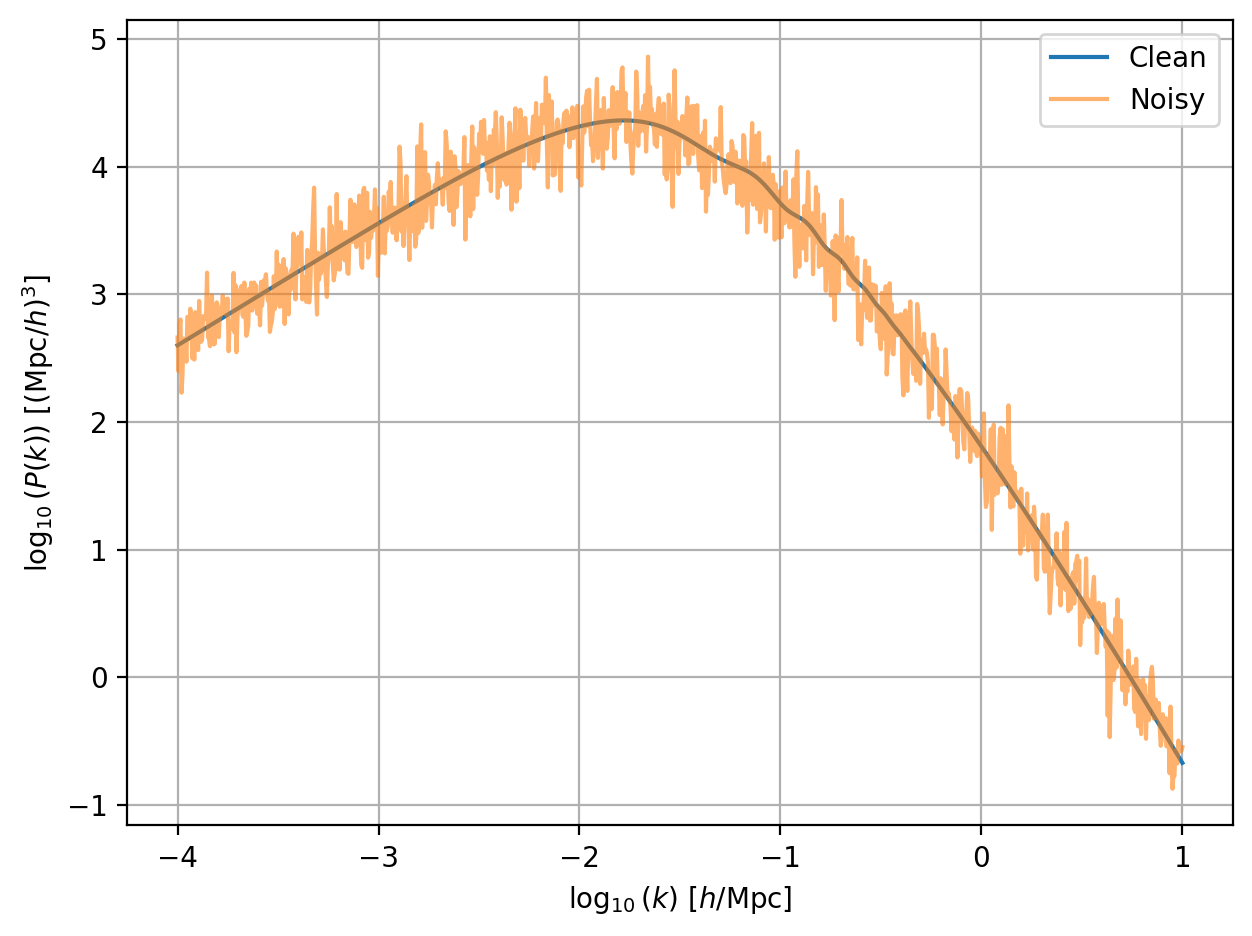

In [5]:
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_clean'], label='Clean')
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel(r'$\log_{10}(k)\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\log_{10}(P(k))\ [(\mathrm{Mpc}/h)^3]$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

$f(P\_k))$, probability density of power spectrum

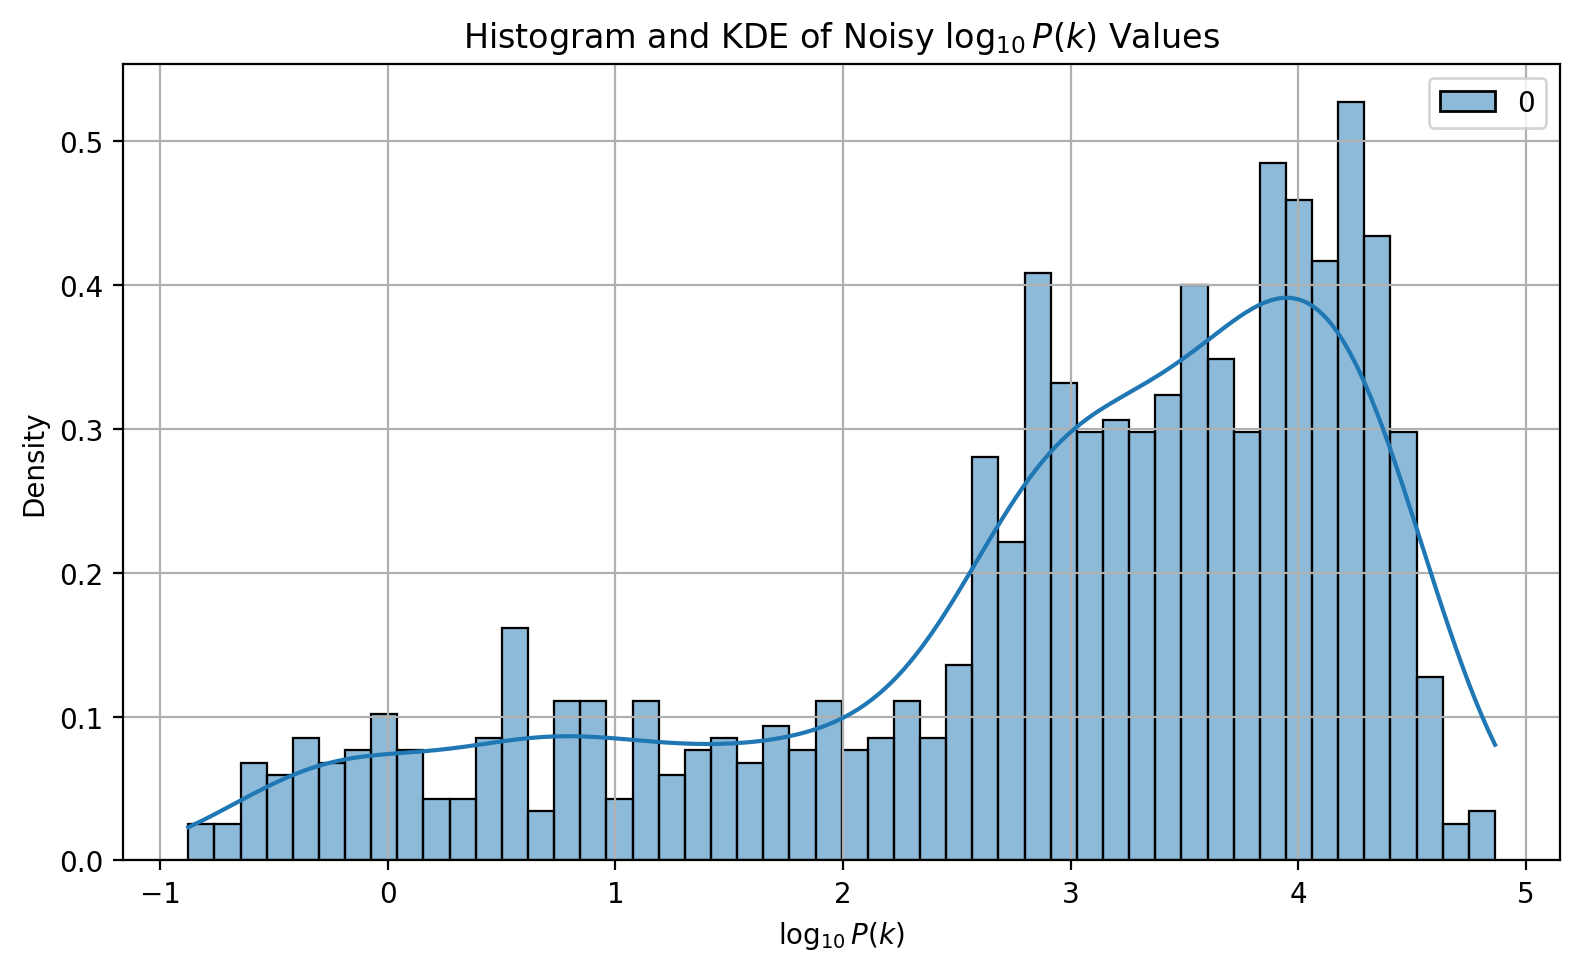

In [6]:

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_obs['log_P_k_noisy'], bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


# Bayes Flow

Prior: $(\theta^{(s)}) \sim P(\theta)$

In [7]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(30, 100)
    Omega_m = rng.uniform(0.1, 0.6)
    n_s = rng.uniform(0.8, 1.5)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


# Prior Plots

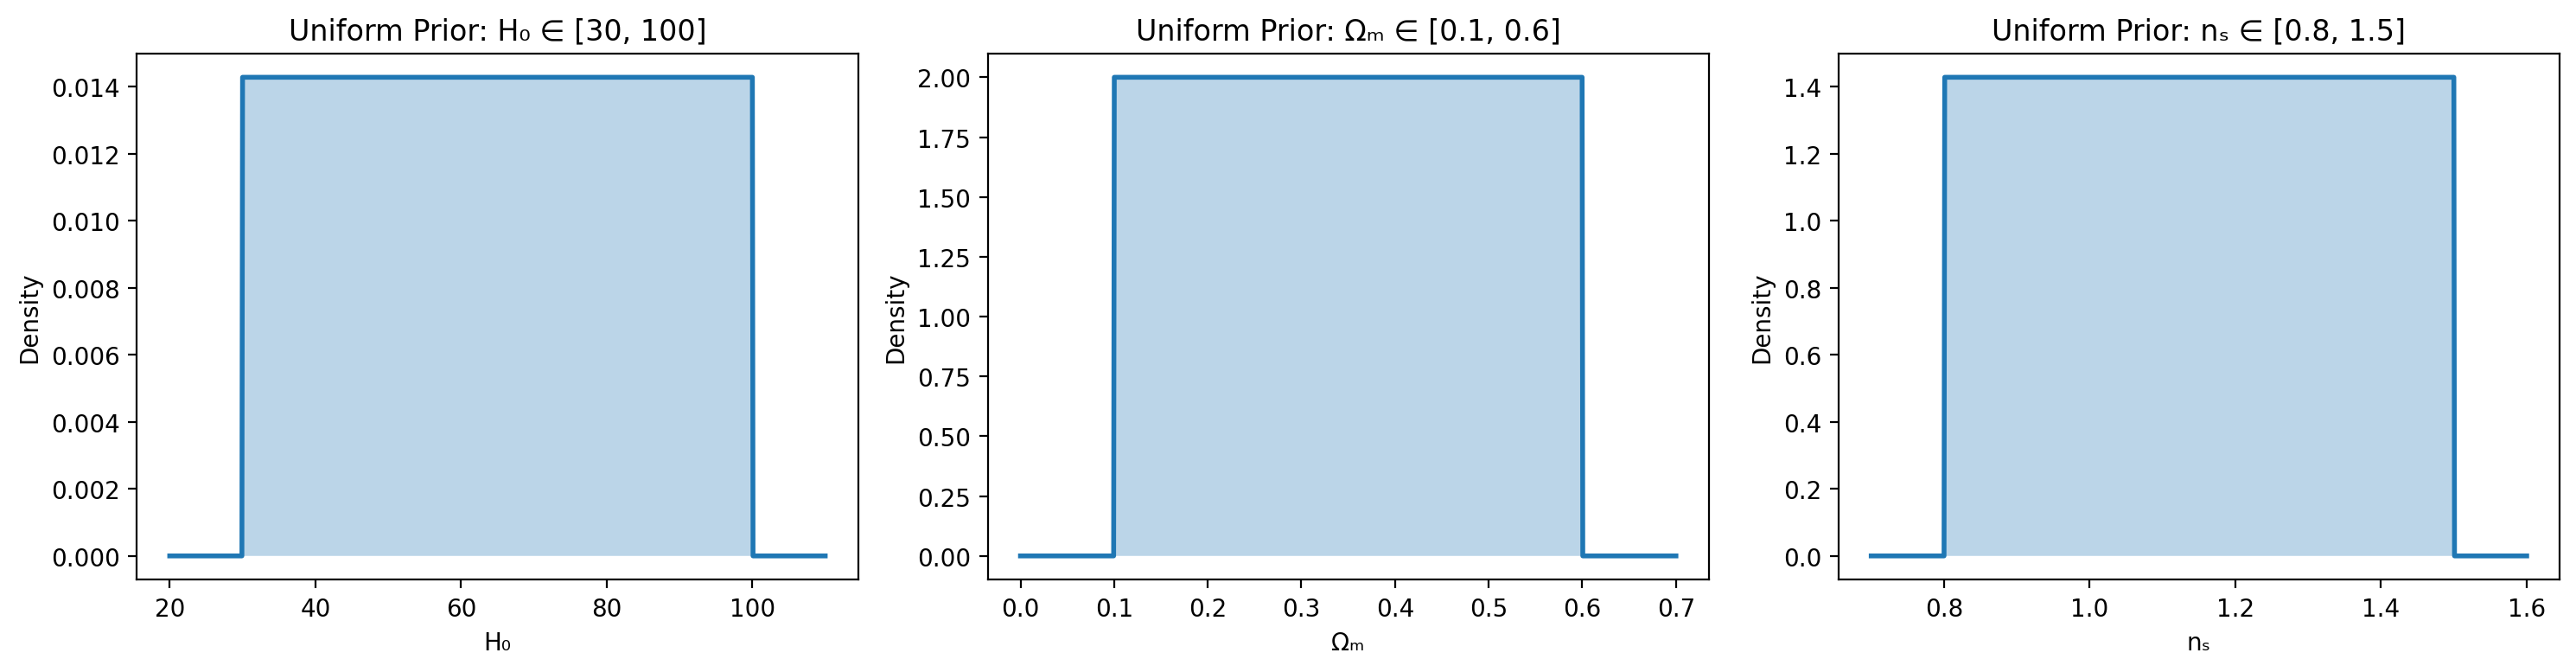

In [141]:

# Parameter ranges
H0_range = (30, 100)
Om_range = (0.1, 0.6)
ns_range = (0.8, 1.5)

# Define x values
x_H0 = np.linspace(20, 110, 1000)
x_Om = np.linspace(0, 0.7, 1000)
x_ns = np.linspace(0.7, 1.6, 1000)

# Uniform densities
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Compute densities
y_H0 = uniform_density(x_H0, *H0_range)
y_Om = uniform_density(x_Om, *Om_range)
y_ns = uniform_density(x_ns, *ns_range)

# Plotting
plt.figure(figsize=(15, 4))

# H0
plt.subplot(1, 3, 1)
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')

# Ωm
plt.subplot(1, 3, 2)
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')

# ns
plt.subplot(1, 3, 3)
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')
plt.tight_layout()

# Save as high-resolution PNG
plt.savefig("uniform_priors.png", dpi=300, bbox_inches='tight')
plt.show()


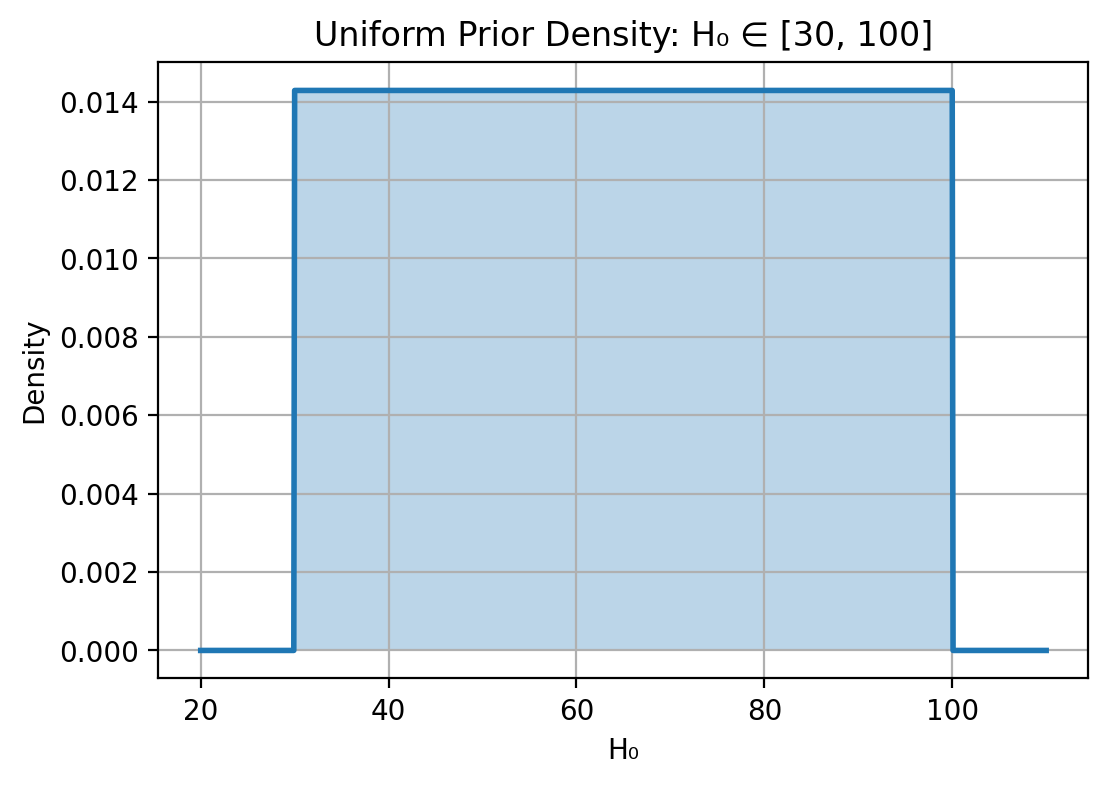

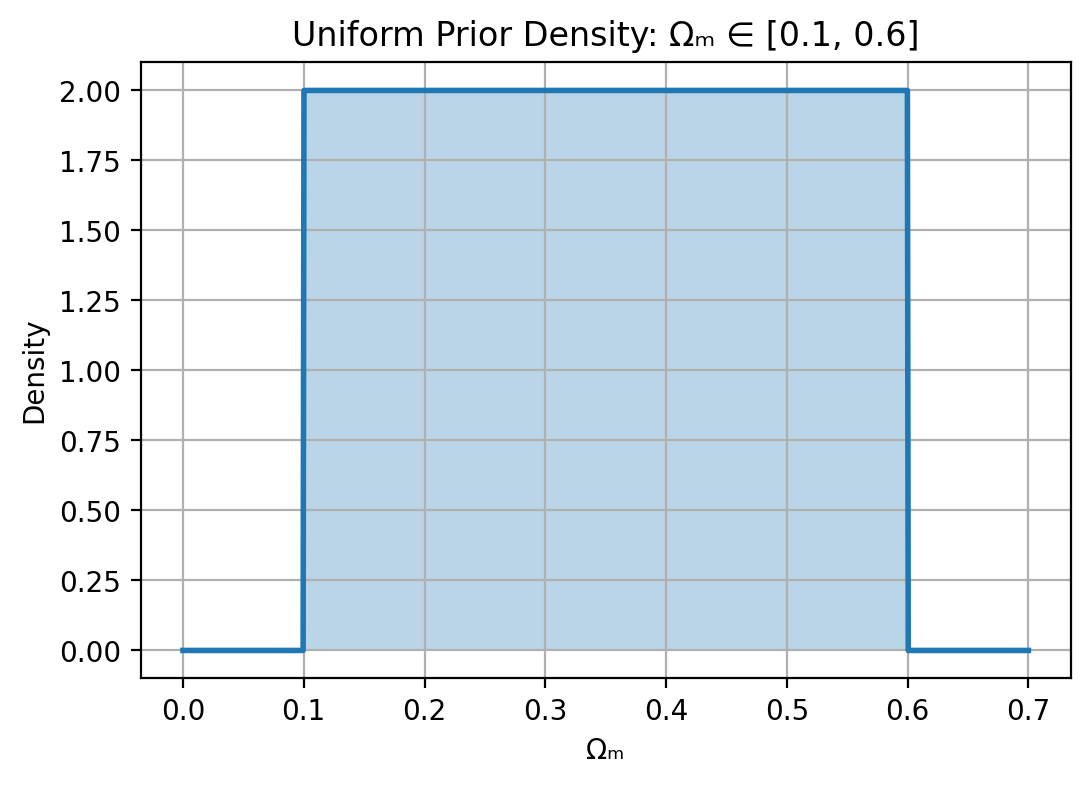

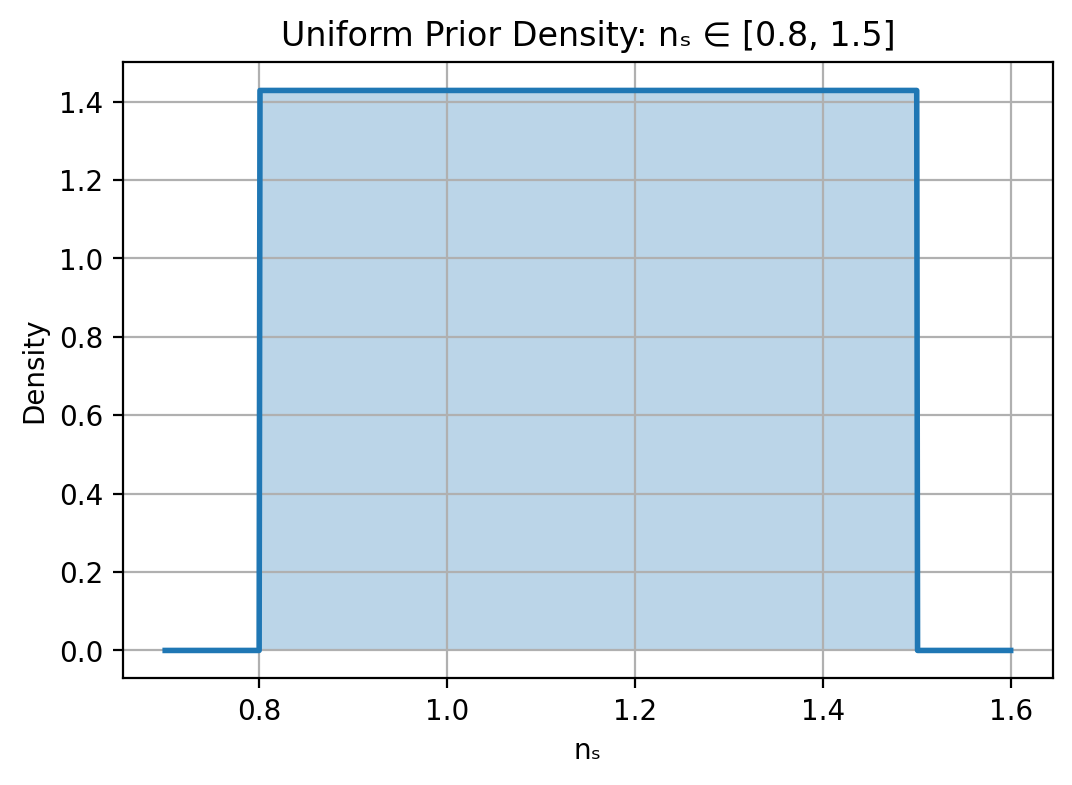

In [9]:
# Uniform density function
def uniform_density(x, a, b):
    return np.where((x >= a) & (x <= b), 1 / (b - a), 0)

# Plot 1: Hubble constant H0
x_H0 = np.linspace(20, 110, 1000)
y_H0 = uniform_density(x_H0, 30, 100)

plt.figure(figsize=(6, 4))
plt.plot(x_H0, y_H0, lw=2)
plt.fill_between(x_H0, 0, y_H0, alpha=0.3)
plt.title('Uniform Prior Density: H₀ ∈ [30, 100]')
plt.xlabel('H₀')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 2: Matter density Ωm
x_Om = np.linspace(0, 0.7, 1000)
y_Om = uniform_density(x_Om, 0.1, 0.6)

plt.figure(figsize=(6, 4))
plt.plot(x_Om, y_Om, lw=2)
plt.fill_between(x_Om, 0, y_Om, alpha=0.3)
plt.title('Uniform Prior Density: Ωₘ ∈ [0.1, 0.6]')
plt.xlabel('Ωₘ')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: Spectral index ns
x_ns = np.linspace(0.7, 1.6, 1000)
y_ns = uniform_density(x_ns, 0.8, 1.5)

plt.figure(figsize=(6, 4))
plt.plot(x_ns, y_ns, lw=2)
plt.fill_between(x_ns, 0, y_ns, alpha=0.3)
plt.title('Uniform Prior Density: nₛ ∈ [0.8, 1.5]')
plt.xlabel('nₛ')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Likelihood: $(y^{(s)}) \sim P(y | \theta)$
The same function but with just one output of length of k_vals

In [10]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None, n = 256):
    """
    Generate log10 of the noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-4 to 10
        noise_level (float): standard deviation of additive Gaussian noise in log space
        seed (int or None): for reproducibility

    Returns:
        log_P_k_noisy (np.array): noisy log10 power spectrum at z = 0
    """

    if k_vals is None:
        k_vals = np.logspace(-4, 1, n)

    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    h = H0 / 100
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    log_k = np.log10(k_vals)
    log_P_k_clean = np.log10(P_k)
    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise


    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {
        'log_P_k_noisy': log_P_k_noisy
    }

### Testing Prior and Likelihood

In [11]:
theta_test = prior()
print(theta_test)

{'H0': 35.144883225814084, 'Omega_m': 0.4263827795521209, 'n_s': 1.4229190205259847}


In [12]:
# Generate the noisy power spectrum using theta_star
Log_Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    n = 512
)

In [13]:
Log_Pk_test.keys()

dict_keys(['log_P_k_noisy'])

In [14]:
Log_Pk_test['log_P_k_noisy'].shape

(512, 1)

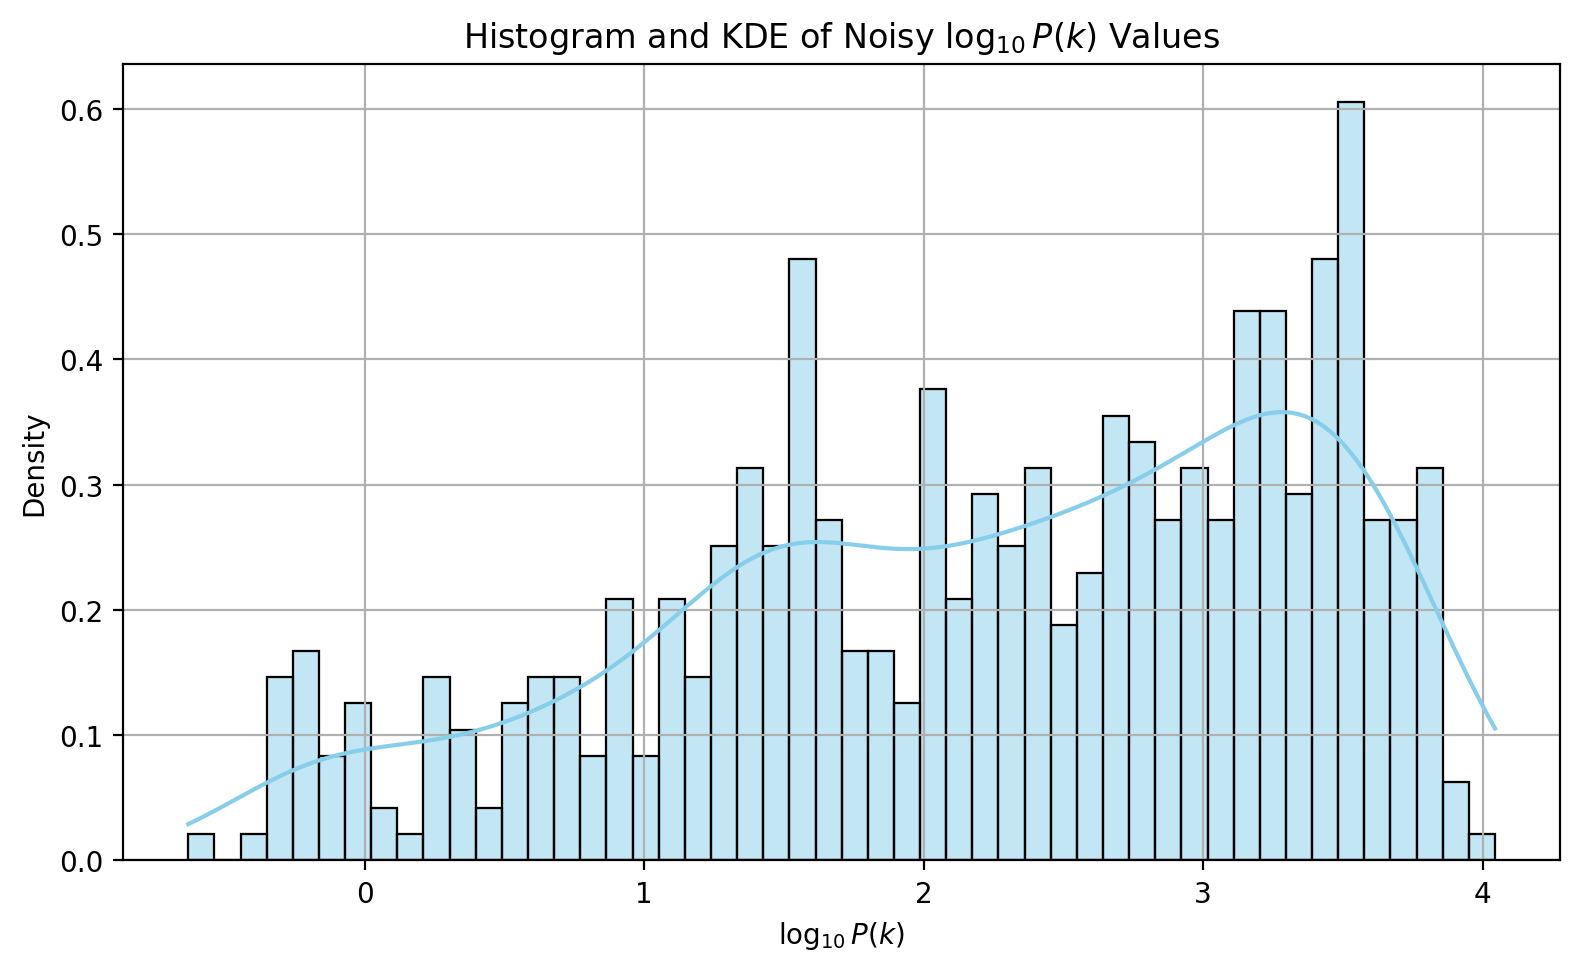

In [142]:
# Plot histogram and KDE for log10(P(k))
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_test['log_P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()

plt.savefig("hist_kde_y.png", dpi=300, bbox_inches='tight')
plt.show()


# --------------------------  Bayes Flow  --------------------------------------

### Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [16]:
simulator = bf.make_simulator([prior, likelihood])

###  Adapter 

In [92]:
adapter_std = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
)

### Summary Networks

In [143]:
class CNNSummaryNet(tf.keras.Model):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        ## Layer 1 
        # 32 filters, kernel 3, activation ReLu
        self.conv1 = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)

        ## Layer 2
        self.conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)

        ## Layer 3
        self.conv3 = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        
        ### Outer layer
        self.dense = tf.keras.layers.Dense(latent_dim, activation='relu')

    def build(self, input_shape):
        
        # Build layers dynamically (important for BayesFlow)
        dummy_input = tf.zeros(input_shape)
        self.call(dummy_input)
        super().build(input_shape)

    def call(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.global_pool(x)
        return self.dense(x)

    def compute_metrics(self, summary_variables, stage=None):
        outputs = self(summary_variables)
        return {"outputs": outputs}

    def compute_output_shape(self, input_shape):
        
        # Ensure input_shape is a tuple like (batch_size, sequence_length, channels)
        batch_size = input_shape[0] if isinstance(input_shape, tuple) else None
        return (batch_size, self.latent_dim)

# 4) CNN
summary_network_CNN = CNNSummaryNet(latent_dim=32)

## Datasets : Training, Validation, Test

In [94]:
# Training data
with open("training_data.pkl", "rb") as f:
    training_data = pickle.load(f)

print(training_data.keys())  # Should match original keys

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


In [95]:
# Validation data
with open("validation_data.pkl", "rb") as f:
    validation_data = pickle.load(f)

print(validation_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


In [96]:
# Test data
with open("test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

print(test_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


In [97]:
# Load test data
with open("test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

print(test_data.keys())

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])


### 4) Affine + CNN

In [151]:
# affine coupling
inference_network_affine = bf.networks.CouplingFlow()

In [146]:
inference_network_affine = bf.networks.CouplingFlow(
    num_params=3,
    num_coupling_layers=12,         # more than default
    conditions_dim=3,       # <<< IMPORTANT
    transform="affine",            # affine coupling
    use_actnorm=True,              # better conditioning
    permutation="shuffle",         # random perm between layers
)

In [152]:
workflow_affine_CNN = bf.BasicWorkflow(
    inference_network=inference_network_affine,
    summary_network=summary_network_CNN,
    adapter=adapter_std,
    simulator=simulator,
    standardize={"summary_variables": True, "inference_variables": True}
)

In [153]:
# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=20,           # Stop if no improvement after 20 epochs
    restore_best_weights=True # Roll back to the best weights
)

In [154]:
history_affine_CNN = workflow_affine_CNN.fit_offline(
    data = training_data,
    epochs=200,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
    #callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - loss: 4.1953 - val_loss: 4.0519
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.2680 - val_loss: 1.9135
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.7790 - val_loss: 0.1358
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: -0.2344 - val_loss: -0.4391
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: -0.6499 - val_loss: -1.0193
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: -0.8446 - val_loss: -0.9696
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: -1.1569 - val_loss: -1.0706
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: -1.1974 - val_loss: -1.1540
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: -1.0068 - val_loss: -1.4048
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: -0.8572 - val_loss: -1.1203
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: -0.7734 - val_loss: -0.8815
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━

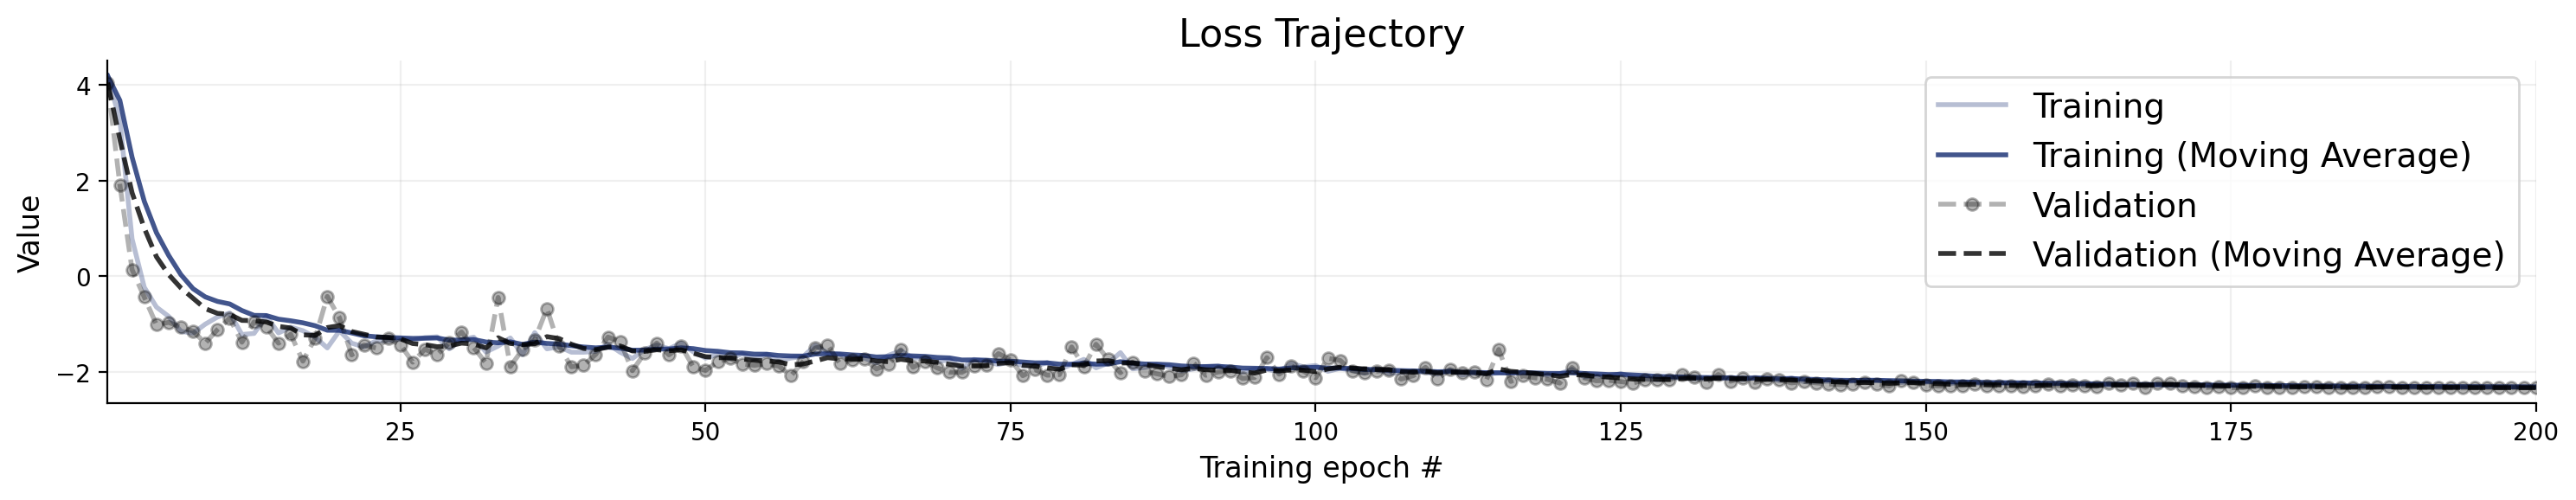

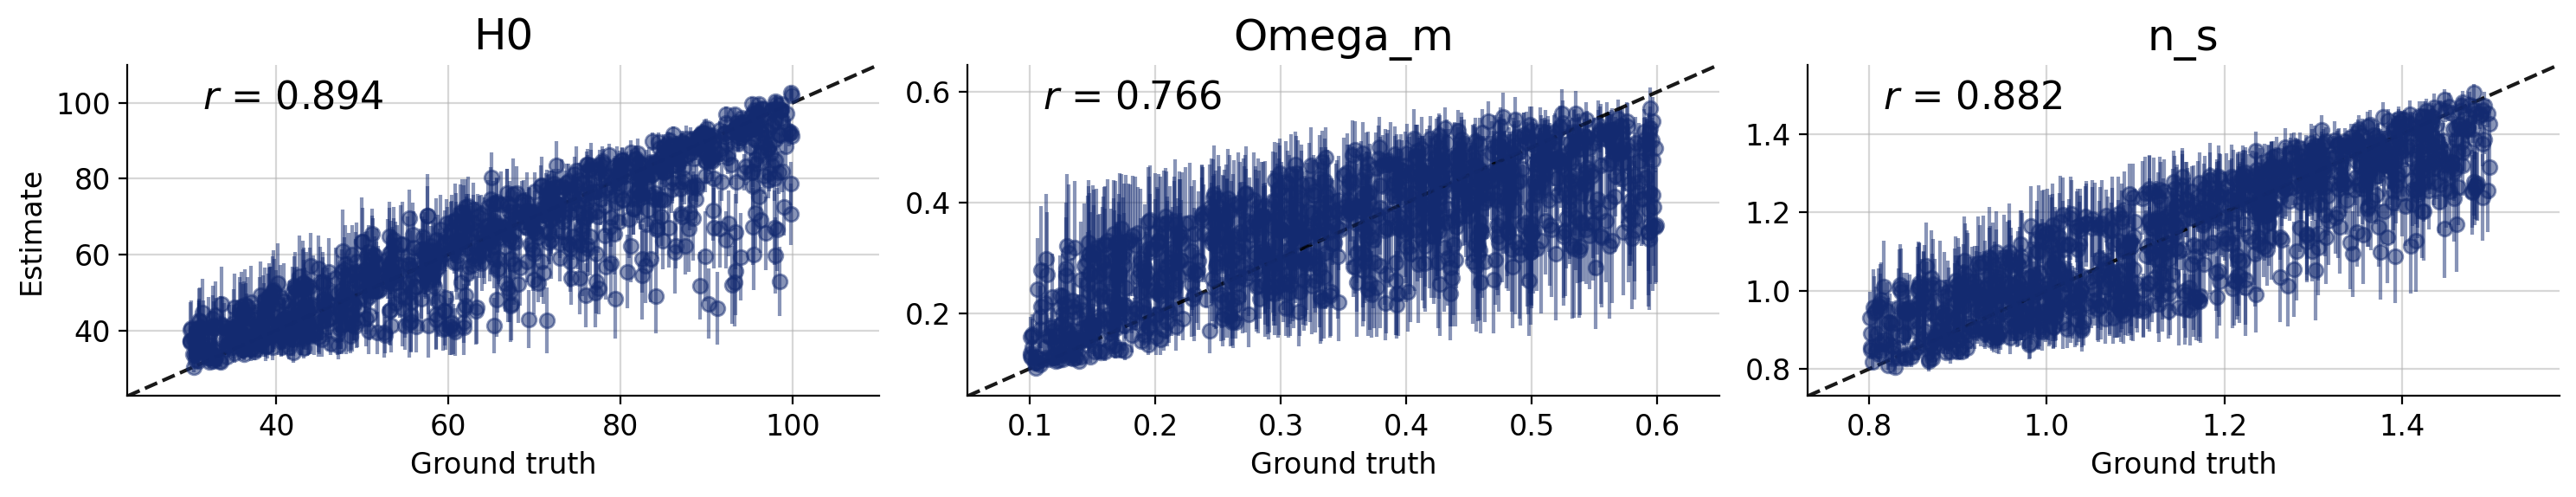

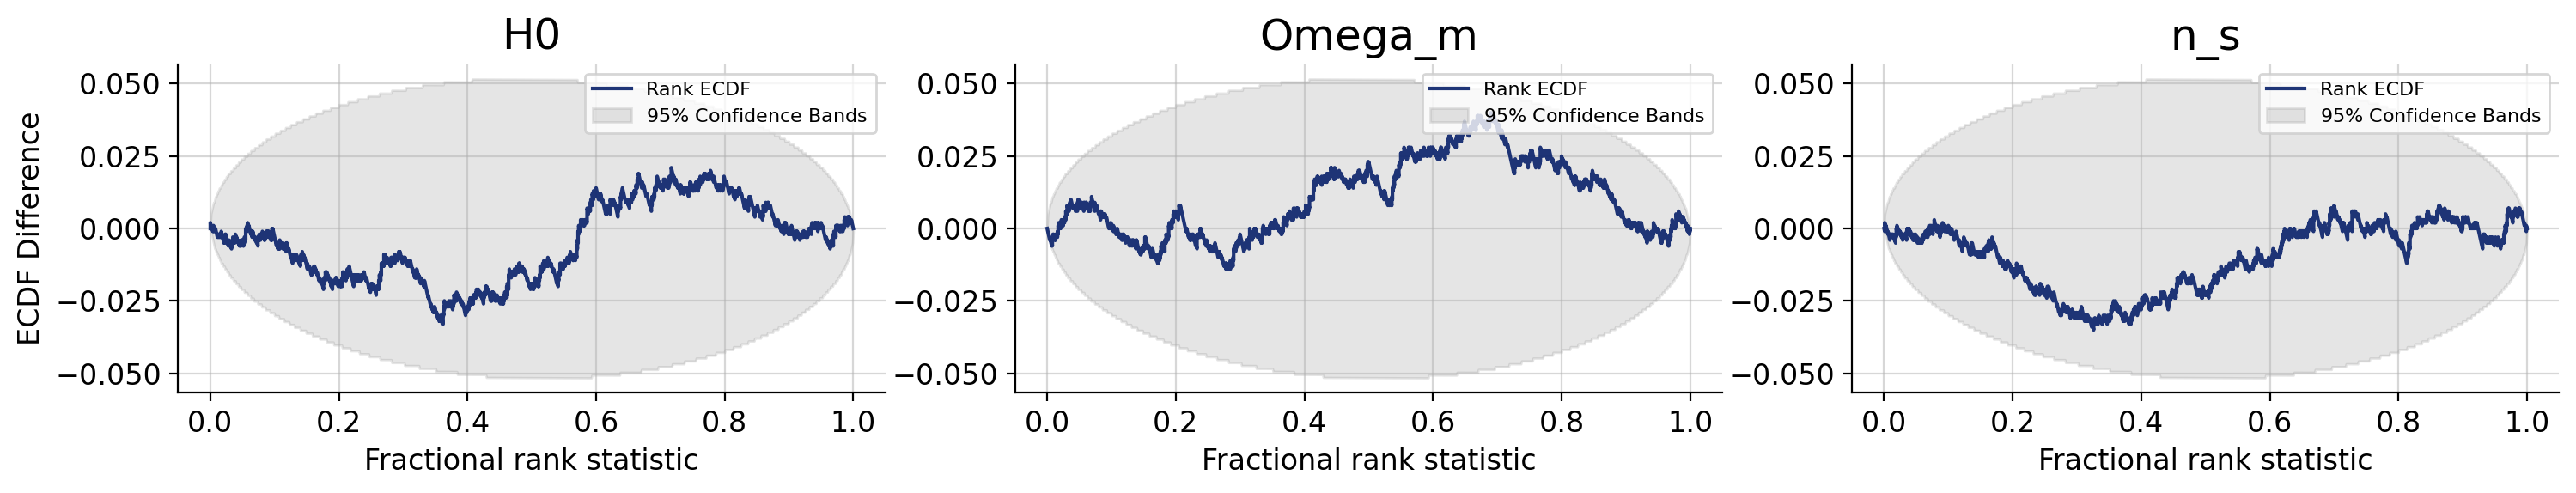

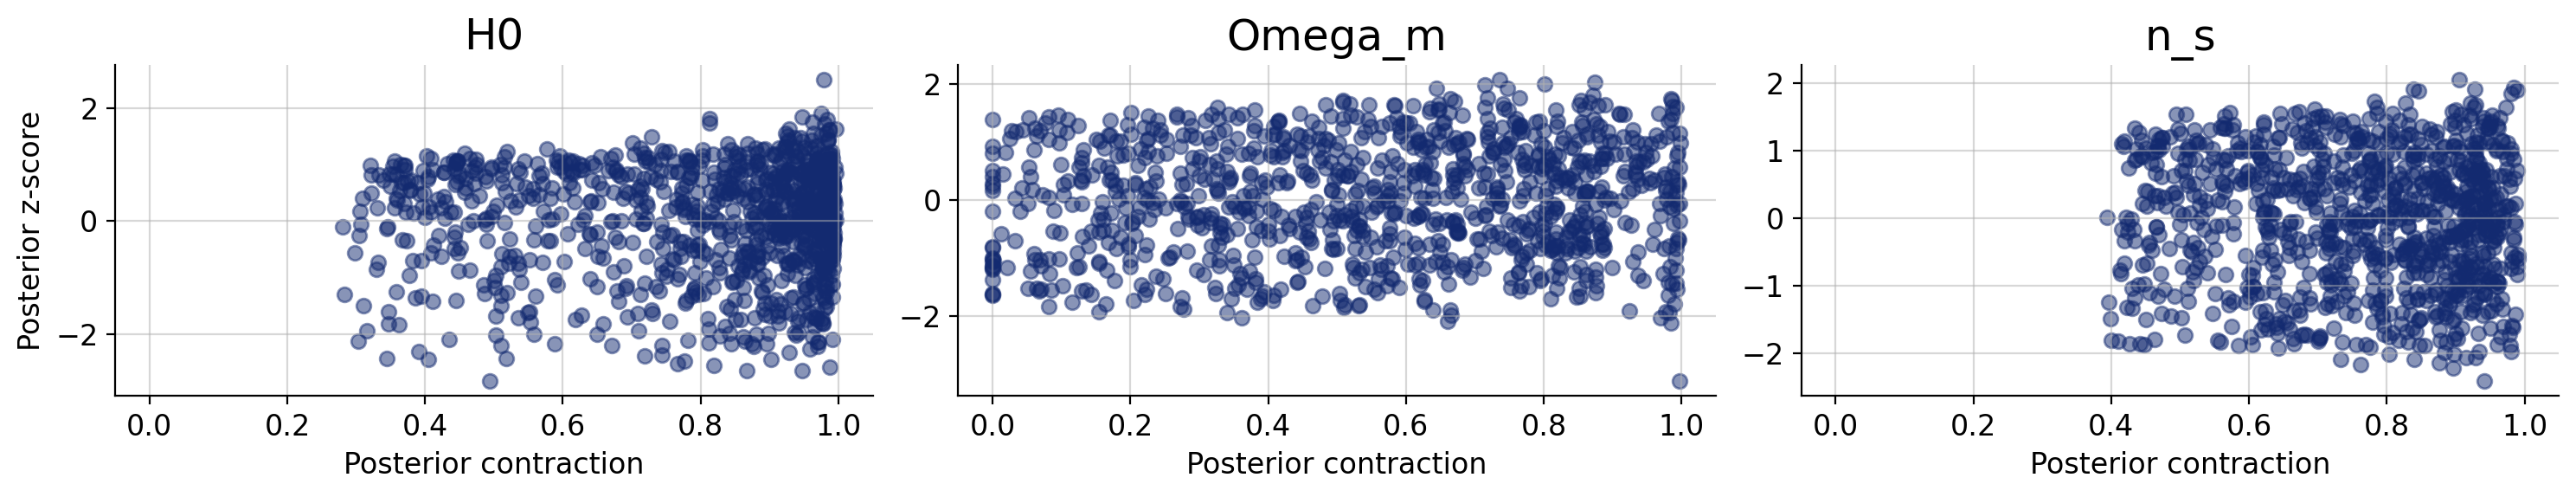

In [155]:
figures_affine_CNN = workflow_affine_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

In [167]:
# Save each figure from the affine CNN diagnostics
for name, fig in figures_affine_CNN.items():
    fig.savefig(f"{name}_affine_CNN.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{name}_affine_CNN.pdf", bbox_inches="tight")  # optional vector format


# Spline + CNN - Coupling Inference Networks

### Spline + CNN

In [161]:
# More expressive Affine Coupling Flow
inference_network_spline = bf.networks.CouplingFlow(
    num_coupling_layers=12,             # Go deeper (more transformations)
    transform="spline",           # Stick to spline (more flexible than affine)
    transform_net_units=[128, 128, 128]
)

In [162]:
# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=20,           # Stop if no improvement after 20 epochs
    restore_best_weights=True # Roll back to the best weights
)

In [163]:
workflow_spline_CNN = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network_CNN,
     adapter=adapter_std,
     simulator=simulator,
    standardize={"summary_variables": True, "inference_variables": True}
)

In [164]:
history_spline_CNN = workflow_spline_CNN.fit_offline(
    data = training_data,
    epochs=200,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
    #callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 141s 207ms/step - loss: 3.1825 - val_loss: 1.7936
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 1.1479 - val_loss: 0.5866
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.3674 - val_loss: 0.0197
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0194 - val_loss: 0.2019
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: -0.2747 - val_loss: -0.4181
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: -0.3880 - val_loss: -0.5242
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: -0.5697 - val_loss: -0.5239
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: -0.7499 - val_loss: -1.2103
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: -0.3726 - val_loss: -0.9051
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: -0.5833 - val_loss: 1.2614
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: -0.0838 - val_loss: -0.6748
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━

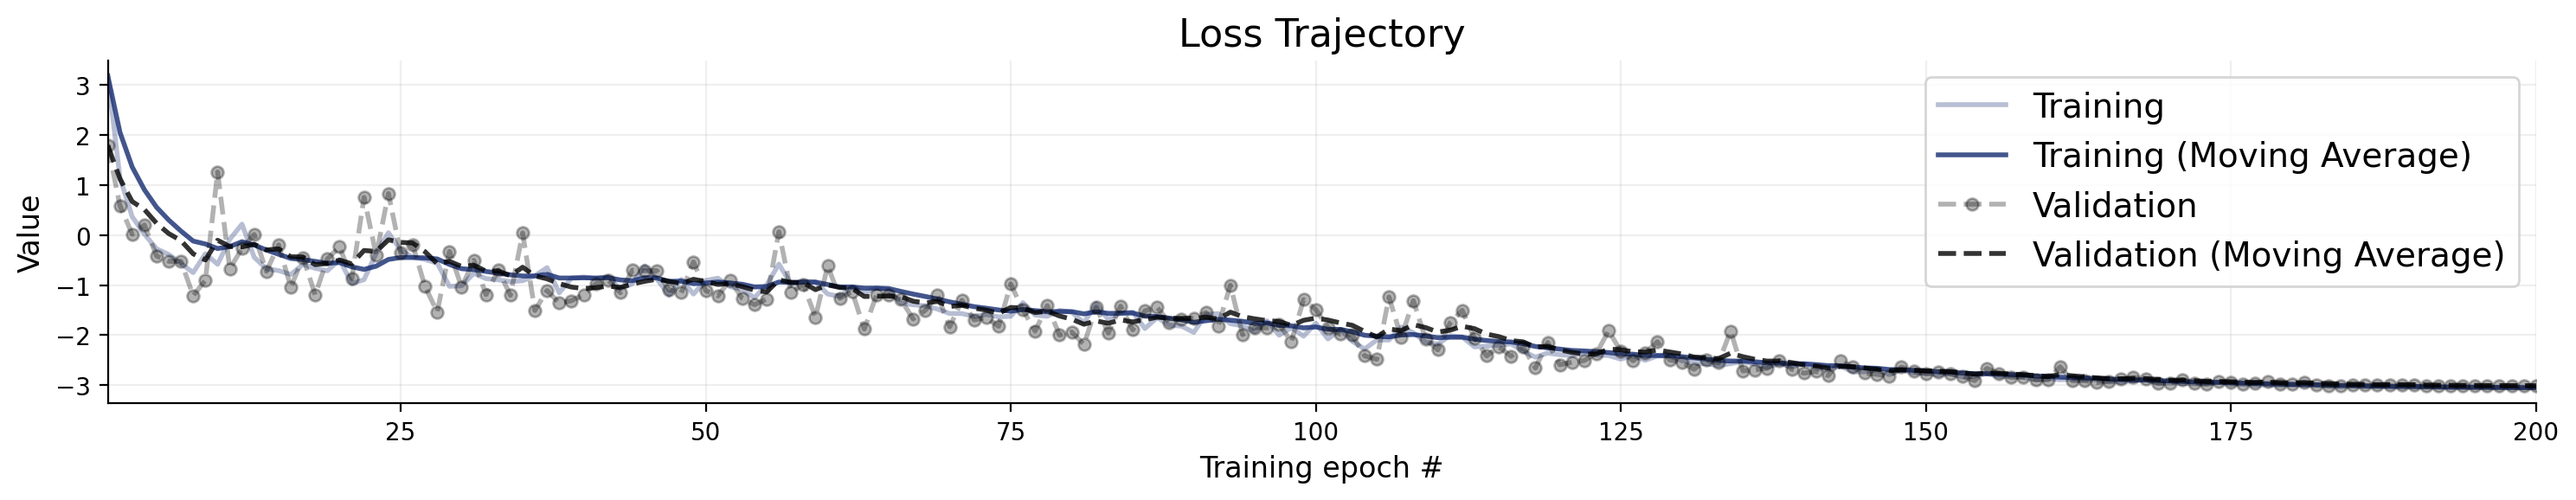

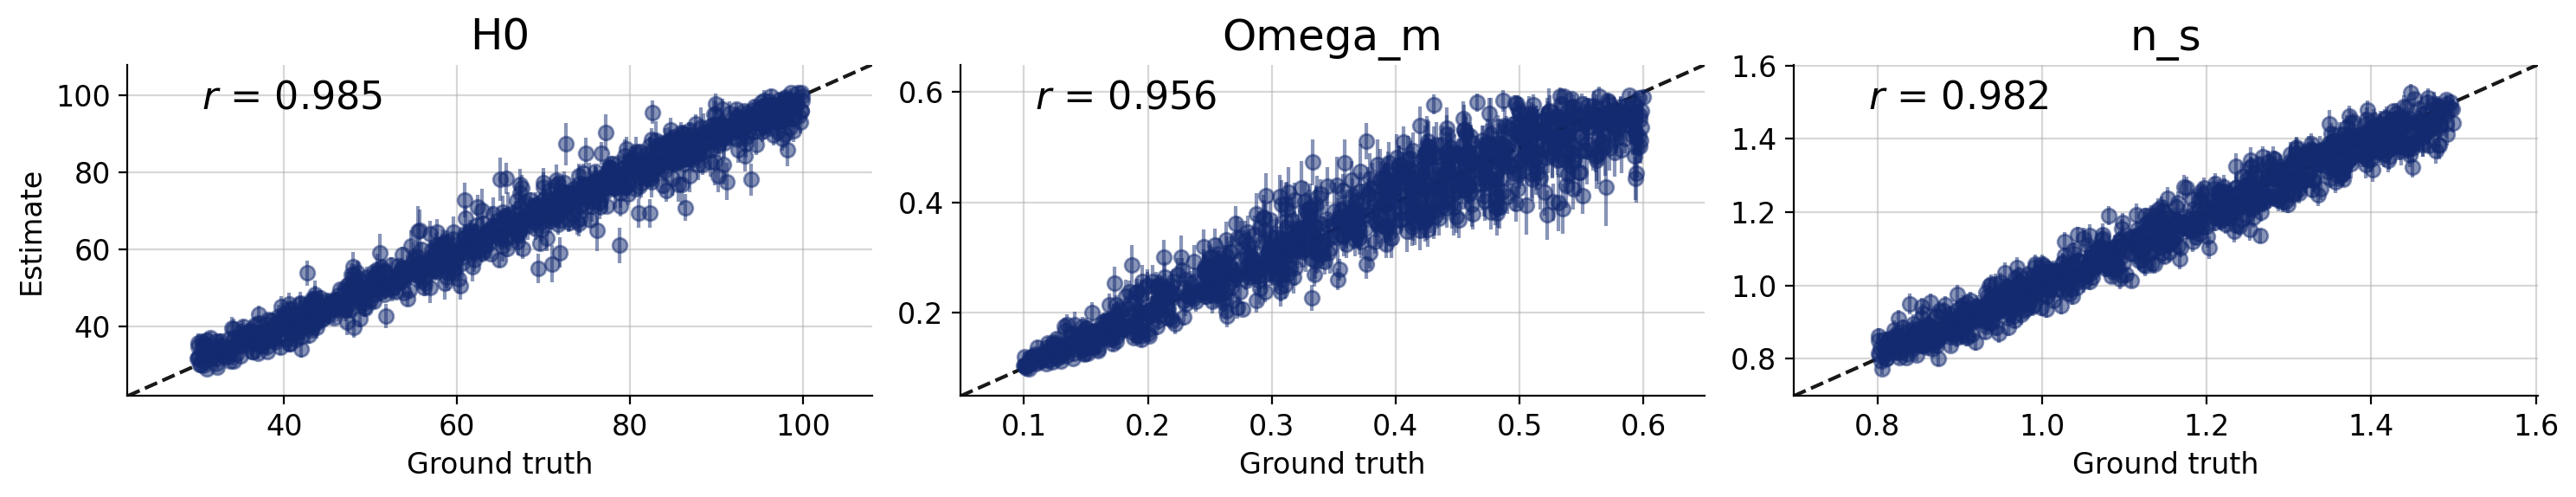

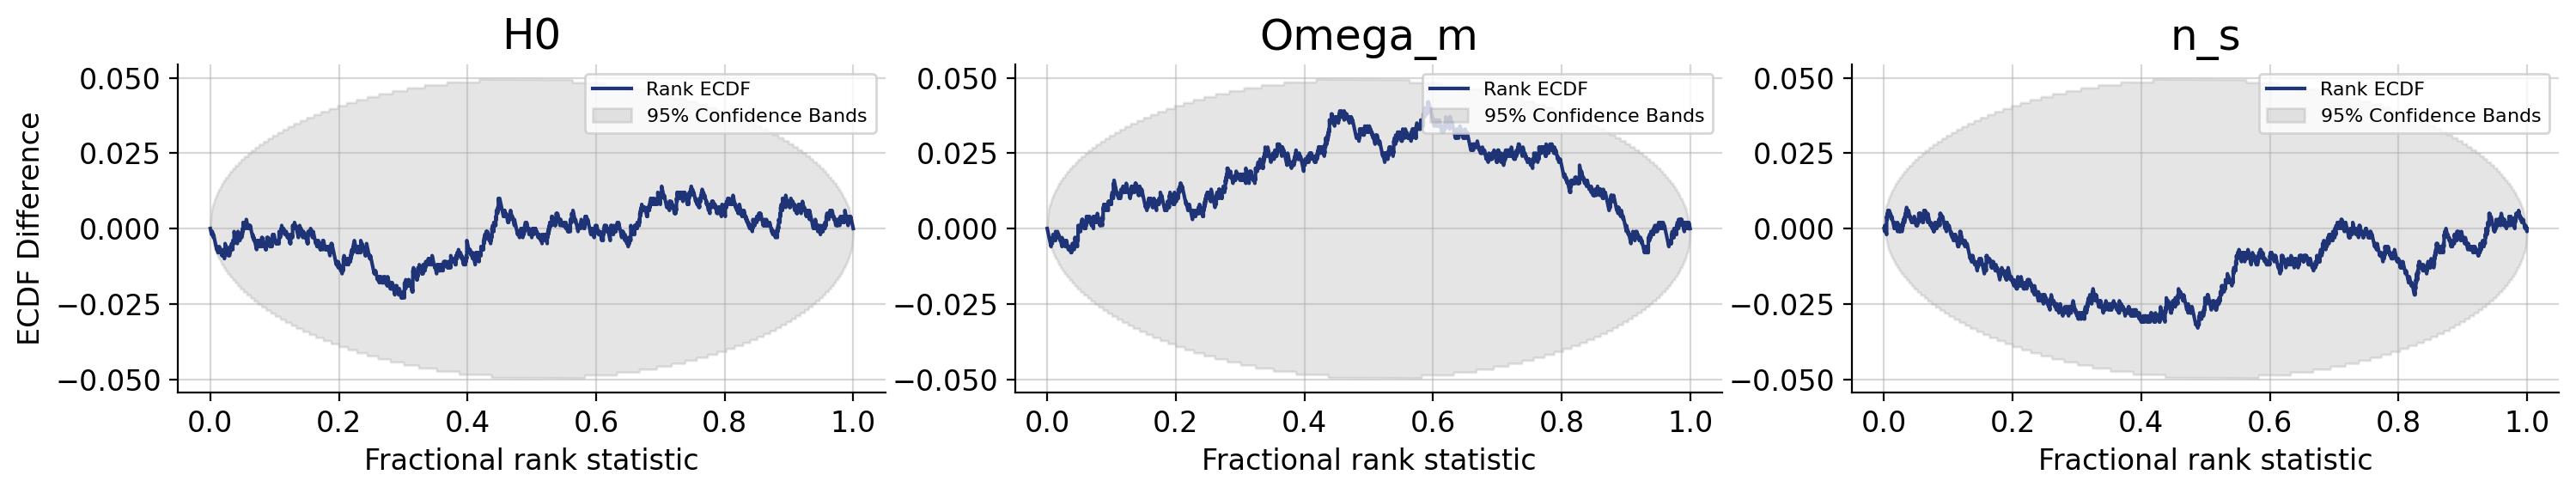

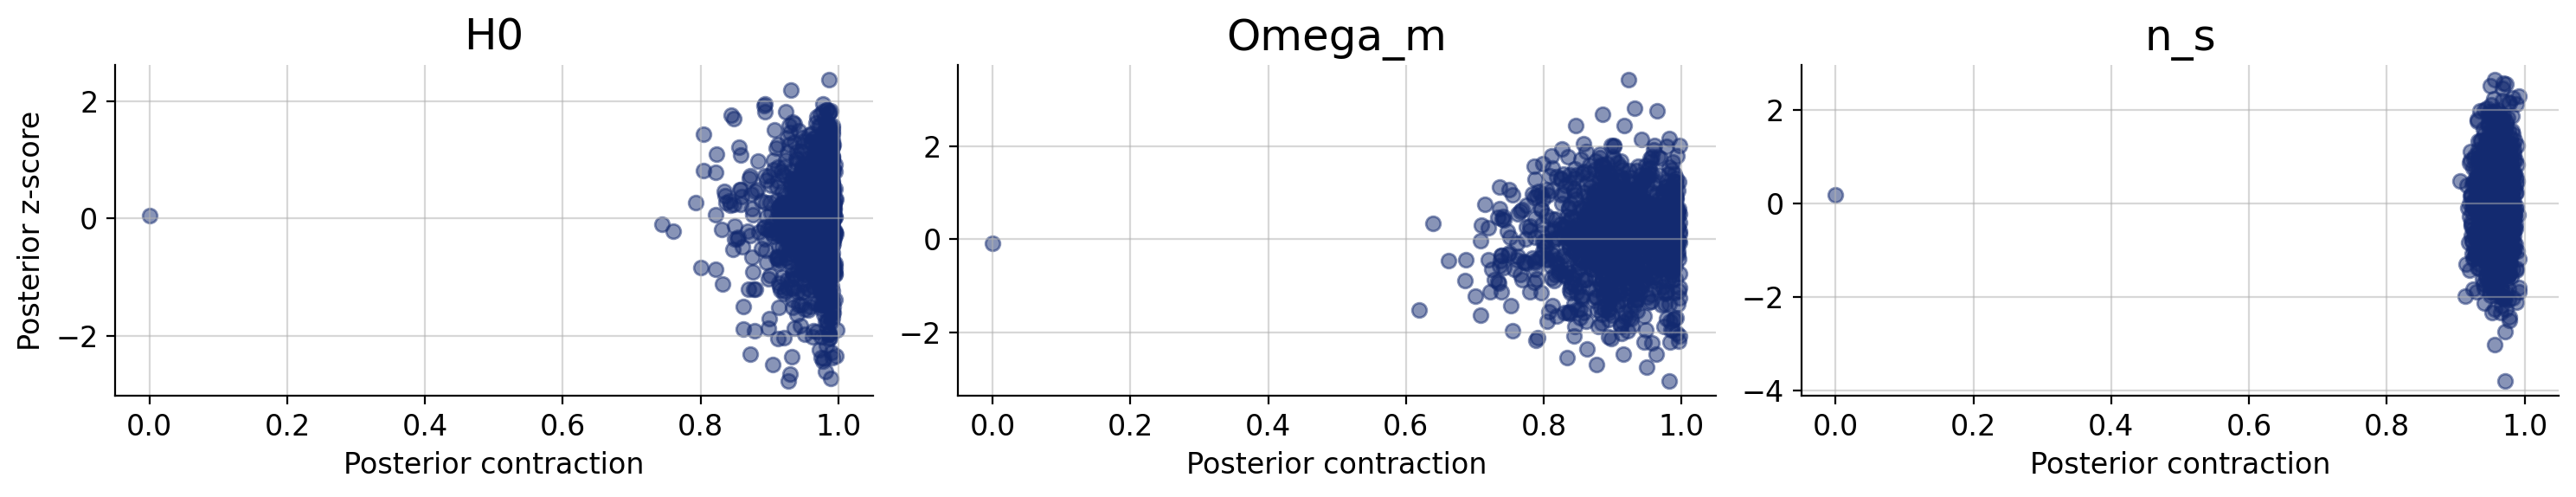

In [165]:
figures_spline_CNN = workflow_spline_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)

In [168]:
# Save each figure from the spline CNN diagnostics
for name, fig in figures_spline_CNN.items():
    fig.savefig(f"{name}_spline_CNN.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{name}_spline_CNN.pdf", bbox_inches="tight")  # optional vector version


In [172]:
test_data.keys()

dict_keys(['H0', 'Omega_m', 'n_s', 'log_P_k_noisy'])

# (C) Flow Matching - Inference Networks

In [173]:
inference_network_flow = bf.networks.FlowMatching()

### 4) Flow + CNN

In [174]:
workflow_flow_CNN = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network_CNN,
     adapter=adapter_std,
     simulator=simulator
)

In [175]:
history_flow_CNN = workflow_flow_CNN.fit_offline(
    data=training_data,
    epochs=200,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data,
    #callbacks=[early_stop]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 1181.0935 - val_loss: 4.4312
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 40.7919 - val_loss: 2.5127
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.4837 - val_loss: 1.3751
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4649 - val_loss: 1.0728
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.1181 - val_loss: 1.1946
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0317 - val_loss: 0.8515
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0116 - val_loss: 1.1238
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.9785 - val_loss: 1.1804
Epoch 9/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.9326 - val_loss: 1.1078
Epoch 10/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.9527 - val_loss: 0.8387
Epoch 11/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.9159 - val_loss: 0.7803
Epoch 12/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms

In [ ]:
figures_flow_CNN = workflow_flow_CNN.plot_default_diagnostics(
    test_data=test_data,
    rank_histogram_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}  
)